In [10]:
options(jupyter.plot_mimetypes = 'image/png')

library("devtools")
library("httr")

library("caret")
library("corrplot")
library(e1071)
library(ggplot2)
library(cowplot)

library(gbm)
library(reshape)
library("R.utils")
library(iptools)
library(bitops)
library(ggmap)
library(maps)
library(cshapes)
library(Imap)
library("zoo")
library("GGally")
library("ggbiplot")
library(gridExtra)
library(mvoutlier)
library("DMwR")
library(plyr)
library(dplyr)
#install.packages("iptools", repos='http://cran.us.r-project.org')

In [1]:
#In order to do a PCA, we need everything as numeric. So let's change the IP address and the
#subnet to integers and then redo the PCA

df <- read.csv('2015_4.71.210.211.data/2015cleaneddata.csv',stringsAsFactors=FALSE)
#the naieve merge I did means that there are header rows every 16000 rows
#These need to be removed...
df$avgrtt <- as.numeric(df$avgrtt) #this will give NA for the header rows
df$day <- as.POSIXct(df$day, format='%Y-%m-%d %H:%M:%S')
df$clientnet<-factor(numeric_to_ip(bitShiftR(ip_to_numeric(df$clientip),16)*2^16))
df$clientsubnum <- ip_to_numeric(df$clientsub)
df$clientipnum <- ip_to_numeric(df$clientip)
df$clientsub <- factor(df$clientsub)
df$countrtt <- as.integer(df$countrtt)
df$rttvar <- as.integer(df$rttvar)
df$client_lat <- as.numeric(df$client_lat)
df$client_lon <- as.numeric(df$client_lon)
df$freqcat<-factor(round(log(df$avg.freq)))
df$rttcat<-factor(round(log(df$avgrtt)))
str(df)

ERROR: Error in factor(numeric_to_ip(bitShiftR(ip_to_numeric(df$clientip), 16) * : could not find function "numeric_to_ip"


In [3]:
#Count how many clients we have had from each clientnet factor
ag<-ddply(df,c("clientsub"),
      summarise,
      count = length(clientip))
clist<-arrange(ag,desc(count))
clist[1:4,]

,clientsub,count
1,190.148.78.0,564
2,23.228.128.0,554
3,187.157.14.0,523
4,173.169.240.0,514


In [13]:
#Now apply this to the original data frame for future splitting:
df2 <- join(df, clist, by ="clientsub", type = "left", match = "first")
head(df2,2)

,clientsub,day,serverport,clientip,clientport,client_lat,client_lon,avgrtt,countrtt,rttvar,...,distToServer,deltat,rollmeant,avg.freq,clientnet,clientsubnum,clientipnum,freqcat,rttcat,count
1,208.0.100.0,2015-01-01 00:11:47,49360,208.0.100.203,18160,13.1000,-59.4833,276.8374,910,50,...,2581.925,100,49.33333,0.02027027,208.0.0.0,3489686528,3489686731,-4,6,4
2,179.26.163.0,2015-01-01 00:12:35,52574,179.26.163.199,58540,-34.8581,-56.1708,1016.3585,159,698,...,7172.946,48,66.00000,0.01515152,179.26.0.0,3004867328,3004867527,-4,7,2


OK, the goal here is to find out how many clients we have coming from each client network. That way we have an idea about how we could train them.

With the big groups, we can start to look at patterns in the queries to look for outliers.

[1] "There are 25 from 144 points, giving  17.3611111111111 % outliers"


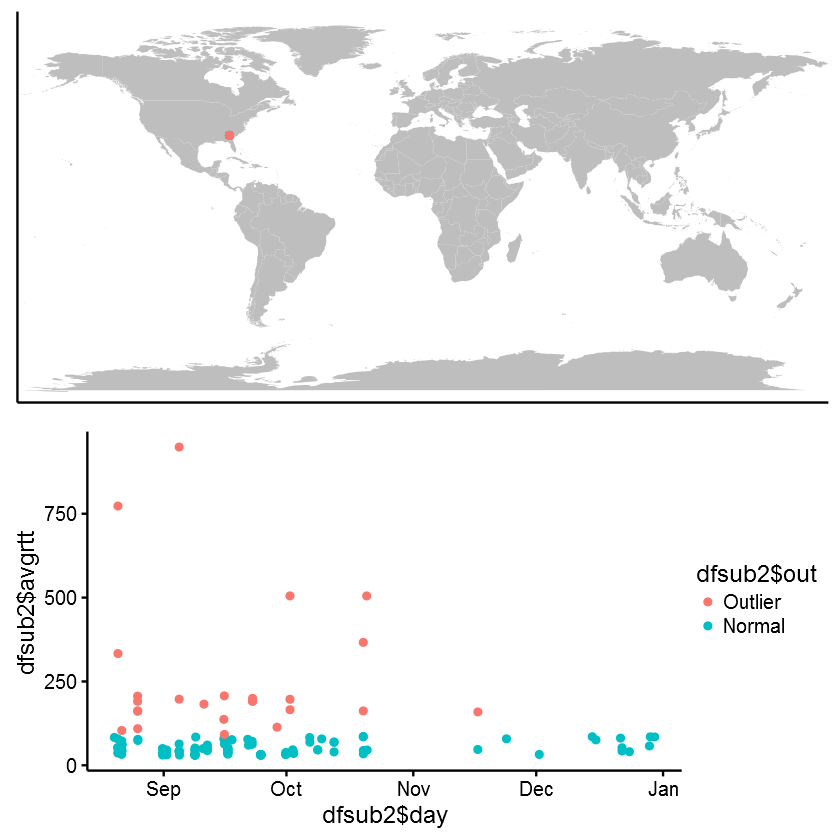

In [16]:
dfone <- df2[df2$clientsub==clist$clientsub[53],]
world_data <- map_data("world")

p1<-ggplot() + scale_y_continuous(limits=c(-90,90), expand=c(0,0)) +
    scale_x_continuous(expand=c(0,0)) +
    theme(axis.ticks=element_blank(), axis.title=element_blank(),
      axis.text=element_blank()) +
    geom_polygon(data=world_data, mapping=aes(x=long, y=lat, group=group), fill='grey') + 
    geom_point(aes(x = client_lon, y = client_lat, color=clientnet,size=count), data = dfone)+
    theme(legend.position = "none") +
      scale_size(range=c(0.1,2))

#get only the numerical data from this dataframe
dfsub <- subset(dfone,select=c(avgrtt))
#Calculate the outliers using a multivariate neighbor algorithm (though we only have one variable...)
dfsub.out<-pcout(dfsub,makeplot=FALSE)
noutliers<-(nrow(dfsub)-sum(dfsub.out$wfinal01))
percoutlier<-(nrow(dfsub)-sum(dfsub.out$wfinal01))/nrow(dfsub)
print(paste("There are",noutliers,"from",nrow(dfsub),"points, giving ",percoutlier*100,"% outliers"))
#Now apply this to the data frame to id the problems
dfsub2 <- dfone
dfsub2$out <-factor(dfsub.out$wfinal01)
levels(dfsub2$out)<-c("Outlier","Normal")
p2<-o
grid.arrange(p1,p2)

In [ ]:
dfsub.out2<-lofactor(dfsub,10)
plot(density(dfsub.out$wfinal))
lines(density(dfsub.out2))

In [ ]:
#Comparing the two outlier detection algorithms:
print(order(dfsub.out2, decreasing=T)[1:15])
print(order(dfsub.out$wfinal, decreasing=F)[1:15])


Ok, the next step is going to be to train the entire data set and then figure out how to judge whether incoming data are outliers or not.